<a href="https://colab.research.google.com/github/shruthiv14/SynapseFI/blob/master/ImageSegmentation_Shruthi_Venkat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The "**Carvana Image Masking Challenge**" ( https://www.kaggle.com/c/carvana-image-masking-challenge ) from Kaggle competitions was chosen to demonstrate Image Segmentation.


Segmentation is the process of partitioning a digital image into multiple segments (sets of pixels) in order to simplify or change the representation of an image into something that is more meaningful and easy to analyze. Traditionally, pixel, edge or region based segmentation were used for this problem. However, with the rise of fast, fully convolution networks that could produce segmentation maps for images of different sizes, the approach to semantic segmentation shifted. Typically, two types of networks evolved - an encoder-decoder architecture style networks and dilated convolutions based networks.


For this project, the following were used:
 
*   **Data:** The dataset was provided by Carvana Co. in the competition. It consists a total of 6500 cars, with 16 images per car taken at different angles. The training set consists of RGB images of about 6100 cars and 1920 x 1080 resolution in 8-bit color depth with JPEG compression. The masks associated with these images were images encoded in GIF format.

*   **Deep CNN Model:** The U-Net architecture, an encoder-decoder based architecture was used for this segmentation project.

*   **Implementation Tools:** The project was implemented on Google Colaboratory with TensorFlow and Keras libraries. The Colaboratory notebook should be used in the GPU accelerator mode.



# Implementation

The dataset can be directly fetched from the Kaggle website using a Kaggle API. The following steps need to be done to create an API token that allows this.







*   Go to the Kaggle website and login to your Kaggle account.
*   Click on your profile button on the top right and then select My Account.
*   Scroll down to the API section and click on the **Create New API Token** button. If you have previous tokens, **Expire API token** before creating a new one.
*   It will initiate the download of a file call kaggle.json . Save the file at a known location on your machine.
*   Then, run the following section of code. It will prompt you to upload a file. At this point, upload the kaggle.json file from the location at which you stored it.
*   Once this is done, run all other sections sequentially.











In [1]:
# Use API token and import kaggle 
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 777 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [0]:
# Run this section only if you see a sample_data folder in the Files Section
# Remove default sample_data folder 
!rm -rf sample_data
#!rm -rf carvana-image-masking-challenge

In [1]:
# Include libraries
import os
from os import listdir
from os.path import isfile, join
import zipfile
import kaggle
import functools
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)
import matplotlib.image as mpimg
from PIL import Image

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend 


In [0]:
# Define dataset as competition data name
dataset = 'carvana-image-masking-challenge'

In [0]:
# Function to fetch data directly from kaggle and unzip only required folders
def get_data(dataset):
  kaggle.api.competition_download_files(dataset, dataset)
  unzip_folders = ['train.zip','train_masks.zip','train_masks.csv.zip','test.zip']
  for folder in unzip_folders:
    fullpath = os.path.join(dataset, folder)
    #print(fullpath)
    with zipfile.ZipFile(os.path.join(dataset, folder), "r") as zip_ref:
      unzipped_file = zip_ref.namelist()[0]
      zip_ref.extractall(dataset)
    !rm -rf "$fullpath"

In [0]:
# Fetch required competition data
get_data(dataset)

In [0]:
# Delete unnecessary folders
req_folders = ['train','train_masks','train_masks.csv','test']
onlyfiles = [f for f in listdir(dataset)]
for f in onlyfiles:
  if f not in req_folders:
    os.remove(os.path.join(dataset,f))

In [0]:
# Identify train images and corresponding mask files
path_train_imgs = os.path.join(dataset, "train")
path_train_labels = os.path.join(dataset,"train_masks")
mask_data = pd.read_csv(os.path.join(dataset,"train_masks.csv")).img.tolist()

mask_img_id = []
for i in mask_data:
  i = i.split('.')[0]
  mask_img_id.append(i)
#print(mask_img_id)



In [0]:
# Function to visualize data samples (images and their corresponding masks)
def data_visualize(total_train, x_train, y_train):
  sample_no = 5
  samples = np.random.choice(total_train,sample_no)

  plt.figure(figsize=(10, 15))
  d = 1
  for i in range(0,sample_no):
    img = samples[i]
    x_path = x_train[img]
    y_path = y_train[img]
  
    plt.subplot(sample_no,2,d)
    plt.imshow(mpimg.imread(x_path))
    plt.title("Original Image")
  
    example_labels = Image.open(y_path)
  
    plt.subplot(sample_no, 2, d+1)
    plt.imshow(example_labels)
    plt.title("Masked Image")  
    d = d + 2 
  
  plt.suptitle("Sample Images and Masks")
  plt.show()

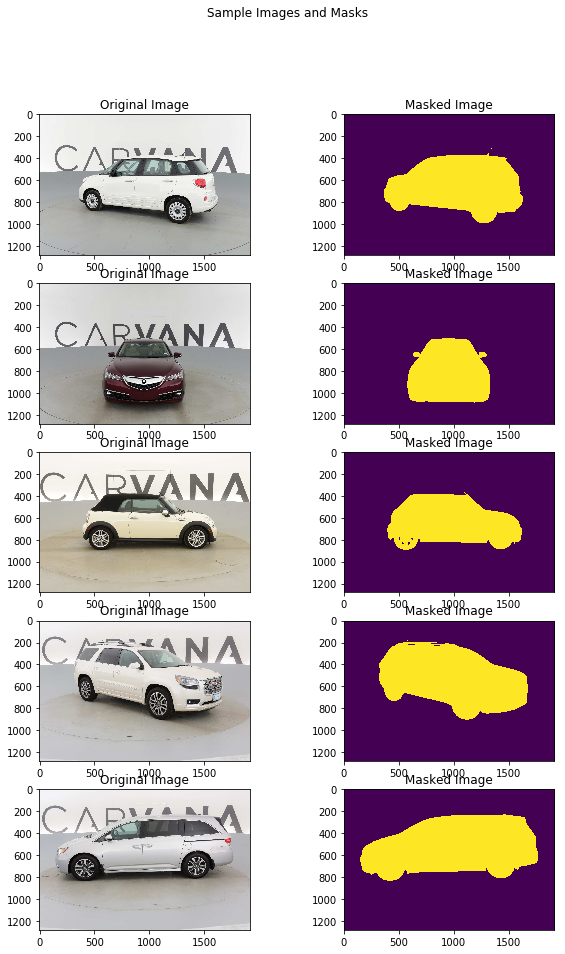

In [8]:
# Define train images and labels(masks) paths
x_train = []
y_train = []
for img in mask_img_id:
  x_train.append(os.path.join(path_train_imgs,"{}.jpg".format(img)))
  y_train.append(os.path.join(path_train_labels,"{}_mask.gif".format(img)))

# Split data into train and validation sets
x_train,x_validation,y_train,y_validation = train_test_split(x_train,y_train,test_size = 0.2,random_state=15)

# Calculate length of train and validation sets
total_train = len(x_train)
total_val = len(x_validation)

#print("Training samples length: {}".format(total_train))
#print("Validation samples length: {}".format(total_val))

data_visualize(total_train, x_train, y_train)

# Set initial parameters
img_shape = (256,256,3)
batch_size = 3
epochs = 5

In [0]:
# Function to get image and mask
def data_from_path(name, label):
  # Get image  
  img_path = tf.read_file(name)
  img = tf.image.decode_jpeg(img_path, channels=3)

  # Get mask (gif ->(num_frames, h, w, c))
  label_path = tf.read_file(label)
  label = tf.image.decode_gif(label_path)[0]  
  label = label[:, :, 0]
  label = tf.expand_dims(label, axis=-1)
  return img, label

In [0]:
# Function to resize images
def image_resize(resize, img, label):
   
  if resize is not None:
    img = tf.image.resize_images(img, resize)
    label = tf.image.resize_images(label, resize)
    
  return img, label

In [0]:
# Function to scale images
  def image_scale(scale, img, label):
    label = tf.to_float(label) * scale
    img = tf.to_float(img) * scale 
    return img, label

In [0]:
# Function to set hue
def image_hue(img, hue_delta):
  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)
  
  return img

In [0]:
# Function to shift images (horizontal and vertical)
def image_shift(img, label, dw, dh):
  if dw or dh:
      
      # Generate random shift distribution to improve shift augmentation
      if dw:
        dw = tf.random_uniform([], -dw * img_shape[1],dw * img_shape[1])
      
      if dh:
        dh = tf.random_uniform([], -dh * img_shape[0], dh * img_shape[0])
      
      img = tfcontrib.image.translate(img, [dw, dh])
      label = tfcontrib.image.translate(label, [dw, dh])
  
  return img, label

In [0]:
# Function to flip images
def image_flip(flip_set, img, label):
  if flip_set:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    img, label = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(img), tf.image.flip_left_right(label)),
                                lambda: (img, label))
  return img, label

In [0]:
# Function to implement data augmentation with following options:
  # Resize the image to required size
  # Scale image
  # Adjust the hue at random for an RGB image
  # Random left right flip
  # Random vertical or horizontal translation
def data_augmentation(img, label, resize=None, scale=1, hue_delta=0, flip_set=False, w_shift=0, h_shift=0):  
  
  img, label = image_resize(resize, img, label)
  img, label = image_scale(scale,img, label)
  img = image_hue(img, hue_delta)
  img, label = image_flip(flip_set, img, label)
  img, label = image_shift(img, label, w_shift, h_shift)
  
  return img, label

In [0]:
# Define all configuration parameters for training dataset preprocessing 
train_config = {
    
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'flip_set': True,
    'w_shift': 0.1,
    'h_shift': 0.1
}
train_preproc = functools.partial(data_augmentation, **train_config)

In [0]:
# Define all configuration parameters for validation dataset preprocessing
validation_config = {
    
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
validation_preproc = functools.partial(data_augmentation, **validation_config)

In [0]:
def get_dataset_struct(filenames, labels, preproc_set=functools.partial(data_augmentation), threads=5, batch_size=batch_size, shuffle=True):           
  
  total = len(filenames)
  print(total)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  
  # Map preprocessing function to each element of dataset
  dataset = dataset.map(data_from_path, num_parallel_calls=threads)
  
  # Ensure all images in batch have same size
  if preproc_set.keywords is not None and 'resize' not in preproc_set.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_set, num_parallel_calls=threads)
  print(dataset.output_shapes)
  if shuffle:
    dataset = dataset.shuffle(total)
  
  # Iterate over dataset for multiple epochs
  dataset = dataset.repeat().batch(batch_size)
  
  return dataset

In [19]:
# Get train and validation set in defined dataset structure using their respective preprocessing function parameters

train_ds = get_dataset_struct(x_train, y_train, preproc_set=train_preproc, batch_size=batch_size)

val_ds = get_dataset_struct(x_validation, y_validation, preproc_set=validation_preproc, batch_size=batch_size)

W0629 21:12:57.889920 139888178673536 deprecation.py:323] From <ipython-input-11-c68894c8a786>:2: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


4070


W0629 21:12:59.080700 139888178673536 deprecation.py:323] From <ipython-input-18-347825d8d180>:16: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


(TensorShape([Dimension(256), Dimension(256), Dimension(3)]), TensorShape([Dimension(256), Dimension(256), Dimension(1)]))
1018
(TensorShape([Dimension(256), Dimension(256), Dimension(3)]), TensorShape([Dimension(256), Dimension(256), Dimension(1)]))


In [0]:
# Define the U-net model
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [21]:
# Building the network
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

W0629 21:13:07.882666 139888178673536 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Call model functional API with the defined inputs and outputs
model = models.Model(inputs=[inputs], outputs=[outputs])

In [0]:
# Define dice coefficient to calculate dice loss
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [0]:
# Calculate dice loss
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [0]:
# Define a custom loss function which is a combination of binary crossentropy and dice loss
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [26]:
# Compile the model
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

W0629 21:13:28.723670 139888178673536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# Save the model which produced the most desired loss value
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [28]:
# Train the model on train and validation data
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(total_val / float(batch_size))),
                   callbacks=[cp])

Epoch 1/5
1356/1357 [============================>.] - ETA: 0s - loss: 0.0781 - dice_loss: 0.0419
Epoch 00001: val_dice_loss improved from inf to 0.11779, saving model to /tmp/weights.hdf5
1357/1357 [==============================] - 412s 303ms/step - loss: 0.0781 - dice_loss: 0.0419 - val_loss: 0.4169 - val_dice_loss: 0.1178
Epoch 2/5
1356/1357 [============================>.] - ETA: 0s - loss: 0.0319 - dice_loss: 0.0158
Epoch 00002: val_dice_loss improved from 0.11779 to 0.07813, saving model to /tmp/weights.hdf5
1357/1357 [==============================] - 290s 213ms/step - loss: 0.0319 - dice_loss: 0.0158 - val_loss: 0.2357 - val_dice_loss: 0.0781
Epoch 3/5
1356/1357 [============================>.] - ETA: 0s - loss: 0.0275 - dice_loss: 0.0136
Epoch 00003: val_dice_loss improved from 0.07813 to 0.01229, saving model to /tmp/weights.hdf5
1357/1357 [==============================] - 289s 213ms/step - loss: 0.0275 - dice_loss: 0.0136 - val_loss: 0.0237 - val_dice_loss: 0.0123
Epoch 4/

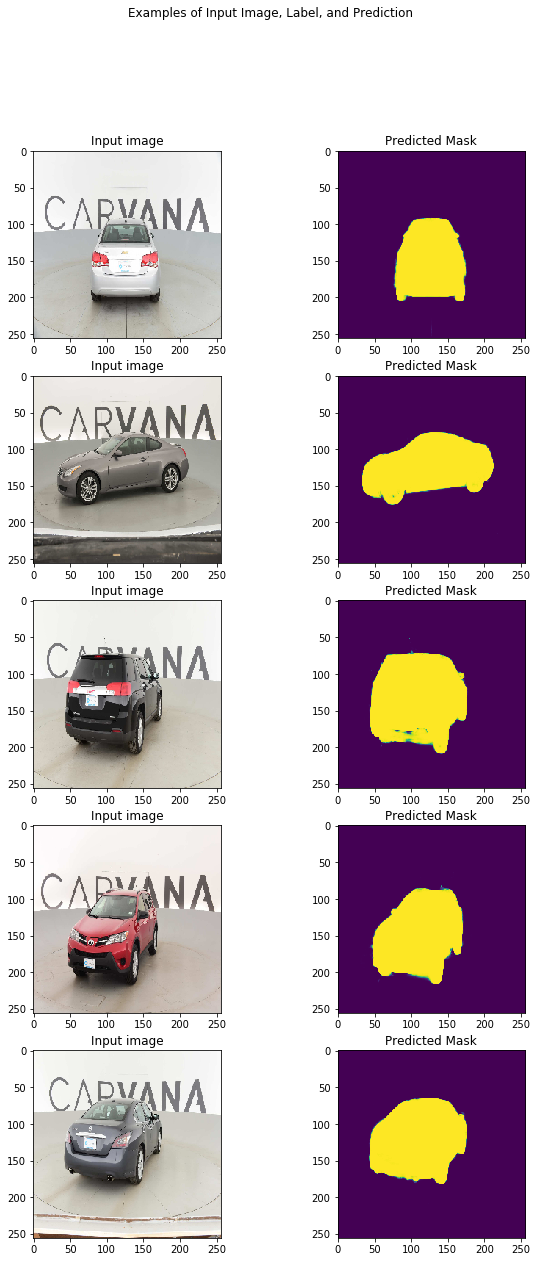

In [31]:
# Test the model on randomly chosen samples of test data and visualize predicted masks 

import cv2
path_test_imgs = os.path.join(dataset,'test')
testfiles = [f for f in listdir(path_test_imgs)]
total_test = len(testfiles)

plt.figure(figsize=(10, 20))
sample_no = 5
samples = np.random.choice(total_test,sample_no)
for i in range(sample_no):
  img = []
  for j in range(batch_size):
    img.append((cv2.resize(mpimg.imread(os.path.join(path_test_imgs,testfiles[samples[i]+j])),(img_shape[0],img_shape[1])))/255)
 
  img_inference = np.array(img,dtype='float32')
  predicted_label = model.predict(img_inference)[0]

  plt.subplot(5, 2, 2 * i + 1)
  plt.imshow(img[0])
  plt.title("Input image")
  
  plt.subplot(5, 2, 2 * i + 2)
  plt.imshow(predicted_label[:,:,0])
  plt.title("Predicted Mask")
plt.suptitle("Input Image and corresponding Mask Prediction")
plt.show()